In [1]:
import sagemaker as sm
import pandas as pd
import numpy as np
import tensorflow as tf
import boto3
from matplotlib import pyplot as plt
%matplotlib inline

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# MNIST Digit Classification with TensorFlow

We're going to try and run a classifier on the classic MNIST data set. We'll put the data in an S3 bucket we create and pull it into this notebook, then spin up an instance for training. Finally, we'll make an endpoint, and use it to test against.

I made a notebook that shows how to use the TensorFlow `estimator` API (which is a higher level of abstraction than directly building a net). So, some of the details of that are omitted here. Insofar as we're using TensorFlow, there's some convoluted syntax, but we're big boys and girls, so we can handle it.

This notebook (more or less) follows the one that can be found in

    sample-notebooks/sagemaker-python-sdk/tensorflow_iris_dnn_classifier_using_estimators
    
I wanted to rewrite it myself with a slightly different dataset to make sure I understood it.

# Initialize Variables

In [2]:
#Bucket location to save your custom code in tar.gz format.
custom_code_upload_location = 's3://peterwills-test/mnist/customcode/tensorflow_mnist'

#Bucket location where results of model training are saved.
model_artifacts_location = 's3://peterwills-test/mnist/artifacts'

#IAM execution role that gives SageMaker access to resources in your AWS account.
role = sm.get_execution_role()

In [3]:
role

'arn:aws:iam::470403475418:role/service-role/AmazonSageMaker-ExecutionRole-20171201T101195'

The fundamental object here is a `sm.tensorflow.TensorFlow` estimator.

In [4]:
from sagemaker.tensorflow import TensorFlow

This estimator is built on top of a model, defined in the model script `mnist_dnn_clf.py`. The logic of the setup of the script `mnist_dnn_clf.py` is given in [the `sagemaker` docs](https://github.com/aws/sagemaker-python-sdk#tensorflow-sagemaker-estimators). There's particular syntax, function names, etc required to make it an acceptable training script for a `sagemaker.tensorflow.TensorFlow` object. Let's examine this object, because it's so fundamental to this process:

In [9]:
?TensorFlow

In [10]:
mnist_clf = TensorFlow(entry_point = 'mnist_dnn_clf.py',
                       role = role,
                       output_path = model_artifacts_location,
                       code_location = custom_code_upload_location,
                       train_instance_count = 1,
                       train_instance_type = 'ml.p2.xlarge',
                       training_steps = 1000,
                       evaluation_steps = 100)

Now we call the `.fit()` method on the estimator. Note that the file names within the directory `data_loc` are given in the script `mnist_dnn_clf.py`.

In [11]:
%%time
data_loc = 's3://peterwills-test/MNIST-data'
mnist_clf.fit(data_loc)

INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-py2-gpu-2017-12-12-19-01-43-484


...................................................................................
 executing startup script (first run)
 2017-12-12 19:08:35,408 INFO - root - running container entrypoint
 2017-12-12 19:08:35,409 INFO - root - starting train task
 2017-12-12 19:08:38,157 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTP connection (1): 169.254.170.2
 2017-12-12 19:08:39,657 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): s3.amazonaws.com
 2017-12-12 19:08:39,779 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): s3.amazonaws.com
 INFO:tensorflow:----------------------TF_CONFIG--------------------------
 INFO:tensorflow:{"environment": "cloud", "cluster": {"master": ["algo-1:2222"]}, "task": {"index": 0, "type": "master"}}
 INFO:tensorflow:---------------------------------------------------------
 INFO:tensorflow:going to training
 2017-12-12 1

 INFO:tensorflow:Loss for final step: 15.5377.
 INFO:tensorflow:Starting evaluation at 2017-12-12-19:09:14
 2017-12-12 19:09:14.223089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1120] Creating TensorFlow device (/device:GPU:0) -> (device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7)
 INFO:tensorflow:Restoring parameters from s3://peterwills-test/mnist/artifacts/sagemaker-tensorflow-py2-gpu-2017-12-12-19-01-43-484/checkpoints/model.ckpt-1000
 INFO:tensorflow:Evaluation [1/100]
 INFO:tensorflow:Evaluation [2/100]
 INFO:tensorflow:Evaluation [3/100]
 INFO:tensorflow:Evaluation [4/100]
 INFO:tensorflow:Evaluation [5/100]
 INFO:tensorflow:Evaluation [6/100]
 INFO:tensorflow:Evaluation [7/100]
 INFO:tensorflow:Evaluation [8/100]
 INFO:tensorflow:Evaluation [9/100]
 INFO:tensorflow:Evaluation [10/100]
 INFO:tensorflow:Evaluation [11/100]
 INFO:tensorflow:Evaluation [12/100]
 INFO:tensorflow:Evaluation [13/100]
 INFO:tensorflow:Evaluation [14/100]
 INFO:tenso

Looks like it worked!

# Use Classifier to Predict

## Instantiate an Endpoint

Now we'll spin up an endpoint that allows us to make predictions.

In [17]:
%%time
mnist_predictor = mnist_clf.deploy(initial_instance_count=1,instance_type='ml.c4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-py2-gpu-2017-12-12-19-01-43-484
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-py2-gpu-2017-12-12-19-01-43-484


---------------------------------------------------------------------------------------------------------------------------------------------------!CPU times: user 612 ms, sys: 32 ms, total: 644 ms
Wall time: 12min 29s


Let's pull in a few samples from our training data set to see what prediction we have for them:

In [13]:
# download file from s3 to this directory
s3 = boto3.resource('s3')
s3.Bucket('peterwills-test').download_file('MNIST-data/mnist_test.csv', 'mnist_test.csv')

# put into pandas to grab first row:
mnist_test = pd.read_csv('mnist_test.csv')

In [14]:
# separate row into data and label
test_image = np.array(mnist_test.iloc[10,:-1])
test_label = np.array(mnist_test.iloc[10,-1])

Label given in 6


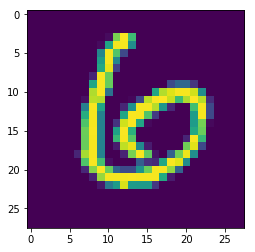

In [15]:
# take a look to make sure it all makes sense
plt.imshow(test_image.reshape(28,28));
print('Label given in {}'.format(test_label))

Now, let's run our predictor on it:

In [16]:
predictions = mnist_predictor.predict(test_image)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from model with message "". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/sagemaker-tensorflow-py2-gpu-2017-12-18-17-19-44-900 in account 470403475418 for more information.

Our predictor gives us the output in a weird nested-dictionary format, so we'll use the below function to convert it to a series for nice plotting.

In [18]:
def prediction_series(predictions):
    """Transform output of SageMaker predictor into a Pandas series"""
    prediction_list = predictions['result']['classifications'][0]['classes']
    results = pd.Series()
    for prediction in prediction_list:
        results[prediction['label']] = prediction['score']
    return results

In [19]:
# logits are nicer than raw probabilities
def logit(p):
    return np.log(p/(1-p))

Now we're ready to plot the output (in log-odds) of our predictor.

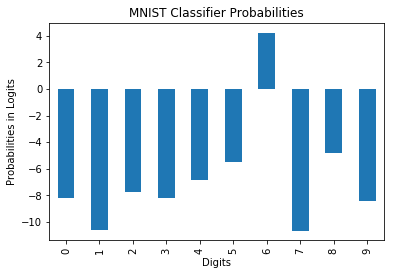

In [48]:
logit(prediction_series(predictions)).plot.bar()
plt.title('MNIST Classifier Probabilities');
plt.xlabel('Digits');
plt.ylabel('Probabilities in Logits');

Beautiful. We see that the correct digit 6 is highly favored. Now let's get rid of the endpoint, since we're not going to keep using it.

### Delete Endpoint

In [46]:
# delete the endpoint when you're done to save resources
sm.Session().delete_endpoint(mnist_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: sagemaker-tensorflow-py2-gpu-2017-12-12-19-01-43-484


# Using Custom Model

Now we'll repeat the process, but using the model script `mnist_custom_model_clf.py`. This one doesn't use the pre-packaged `tf.estimator.DNNClassifier`, but rather defines a custom model. This may become important to us in the future.

In [35]:
mnist_clf = TensorFlow(entry_point = 'mnist_custom_model_clf.py',
                       role = role,
                       output_path = model_artifacts_location,
                       code_location = custom_code_upload_location,
                       train_instance_count = 1,
                       train_instance_type = 'ml.p2.xlarge',
                       training_steps = 1000,
                       evaluation_steps = 100)

In [36]:
%%time
data_loc = 's3://peterwills-test/MNIST-data'
mnist_clf.fit(data_loc)

INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-py2-gpu-2017-12-18-18-04-24-202


....................................................................................
executing startup script (first run)
2017-12-18 18:11:14,809 INFO - root - running container entrypoint
2017-12-18 18:11:14,810 INFO - root - starting train task
2017-12-18 18:11:17,506 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTP connection (1): 169.254.170.2
2017-12-18 18:11:19,201 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): s3.amazonaws.com
2017-12-18 18:11:19,374 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): s3.amazonaws.com
INFO:tensorflow:----------------------TF_CONFIG--------------------------
INFO:tensorflow:{"environment": "cloud", "cluster": {"master": ["algo-1:2222"]}, "task": {"index": 0, "type": "master"}}
INFO:tensorflow:---------------------------------------------------------
INFO:tensorflow:going to training
2017-12-18 18:11:19,42

INFO:tensorflow:Loss for final step: 0.854259.
INFO:tensorflow:Starting evaluation at 2017-12-18-18:11:47
2017-12-18 18:11:47.809408: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1120] Creating TensorFlow device (/device:GPU:0) -> (device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7)
INFO:tensorflow:Restoring parameters from s3://peterwills-test/mnist/artifacts/sagemaker-tensorflow-py2-gpu-2017-12-18-18-04-24-202/checkpoints/model.ckpt-1000
INFO:tensorflow:Evaluation [1/100]
INFO:tensorflow:Evaluation [2/100]
INFO:tensorflow:Evaluation [3/100]
INFO:tensorflow:Evaluation [4/100]
INFO:tensorflow:Evaluation [5/100]
INFO:tensorflow:Evaluation [6/100]
INFO:tensorflow:Evaluation [7/100]
INFO:tensorflow:Evaluation [8/100]
INFO:tensorflow:Evaluation [9/100]
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [11/100]
INFO:tensorflow:Evaluation [12/100]
INFO:tensorflow:Evaluation [13/100]
INFO:tensorflow:Evaluation [14/100]
INFO:tensorflow:Evaluation [

In [37]:
%%time
mnist_predictor = mnist_clf.deploy(initial_instance_count=1,instance_type='ml.c4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-py2-gpu-2017-12-18-18-04-24-202
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-py2-gpu-2017-12-18-18-04-24-202


-------------------------------------------------------------------------------------------------------------------------------------------------!CPU times: user 664 ms, sys: 24 ms, total: 688 ms
Wall time: 12min 19s


In [39]:
tensor_proto = tf.make_tensor_proto(values=np.asarray(test_image), 
                                    shape=[1, len(test_image)], 
                                    dtype=tf.float32)

predictions = mnist_predictor.predict(tensor_proto)

In [41]:
predictions

{'outputs': {'logits': {'dtype': 'DT_FLOAT',
   'floatVal': [0.5936474204063416,
    -0.1599368155002594,
    0.5846495628356934,
    0.12370593845844269,
    0.06490009278059006,
    0.022376229986548424,
    0.6902269124984741,
    -0.9378727078437805,
    0.18018554151058197,
    -0.6290104985237122],
   'tensorShape': {'dim': [{'size': '1'}, {'size': '10'}]}}}}

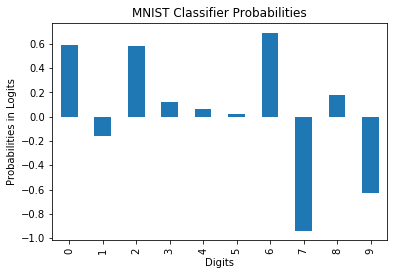

In [42]:
# our model returns logits, not percentages, so no conversion is necessary
pd.Series(predictions['outputs']['logits']['floatVal']).plot.bar()
plt.title('MNIST Classifier Probabilities');
plt.xlabel('Digits');
plt.ylabel('Probabilities in Logits');

In [43]:
# delete the endpoint when you're done to save resources
sm.Session().delete_endpoint(mnist_predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: sagemaker-tensorflow-py2-gpu-2017-12-18-18-04-24-202
